# Summary
In this notebook we'll look at the relations between suicide rates and other statistics about countries, such as happiness levels, economic factors, etc.. 

Rural population data: https://data.worldbank.org/indicator/SP.RUR.TOTL.ZS?view=chart
GDP per capita PPP data: https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD
GDP data: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?name_desc=false


In [78]:
CHOROPLETH_DATA_FILE = '../data/processed/choropleth_df.csv'
GDP_PER_CAPITA = '../data/raw/API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2_443996/API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2_443996.csv'

In [79]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [80]:
df = pd.read_csv(GDP_PER_CAPITA, skiprows=4)
df_original = pd.read_csv(CHOROPLETH_DATA_FILE)

In [81]:
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,35492.618487,34830.976551,36082.522486,36172.933355,35814.261438,35557.656862,35861.828118,NaN,NaN,NaN
1,Afghanistan,AFG,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,1626.764793,1772.764974,1807.762344,1795.735834,1766.593077,1757.023490,1758.465636,1734.723214,NaN,NaN
2,Angola,AGO,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,6346.395122,6645.085625,6730.945822,6813.052106,6644.857255,6258.376628,6044.972035,5725.327238,NaN,NaN
3,Albania,ALB,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,10207.751719,10369.560557,10492.668465,10700.520916,10971.044395,11356.717007,11803.281802,12306.260040,NaN,NaN
4,Andorra,AND,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# remove columns we don't need, rename columns we do want
gdp = df.loc[:, ~df.columns.str.contains('^Unnamed')]
gdp = gdp.rename(columns={"Country Code": "code"}).drop(columns=["Indicator Name", "Indicator Code", "Country Name"])

# pivot
gdp = pd.melt(gdp, id_vars=['code'], var_name='year', value_name='gdp')

# only pick years we want
gdp["year"] = gdp["year"].astype(float)
gdp = gdp[(gdp["year"] < 2015) & (gdp["year"] > 1989)]

num_years = gdp["year"].nunique()
num_countries = gdp["code"].nunique()

assert len(gdp) == num_years * num_countries, "Need every unique (country, year) combination"

# get all codes which have nan values but at least two non-nan values (otherwise can't fill in others really)
null_codes = gdp[gdp["gdp"].isnull()]["code"].value_counts()
null_codes = list(null_codes[null_codes < num_years - 1].index)

# TODO: use df.interpolate() here...
# replace nans with nearest neighbours means (I checked, and this doesn't actually do anything). The nans are all
# are a block at the start or a block at the end
gdp = gdp.sort_values(by="year")
for code in null_codes:
    gdp.loc[gdp["code"] == code, "gdp"] = (gdp.loc[gdp["code"] == code,"gdp"].fillna(method='ffill') + gdp.loc[gdp["code"] == code,"gdp"].fillna(method='bfill'))/2
    
    # if just a single nan, forward fill or backward fill
    if gdp.loc[gdp["code"] == code].isnull().sum()["gdp"] < 5:
        print(code)
        gdp.loc[gdp["code"] == code,"gdp"] = gdp.loc[gdp["code"] == code,"gdp"].fillna(method='ffill')
        if gdp.loc[gdp["code"] == code].isnull().sum()["gdp"] < 5:
            gdp.loc[gdp["code"] == code,"gdp"] = gdp.loc[gdp["code"] == code,"gdp"].fillna(method='bfill')


PSE
BIH
LVA
KHM
SVK
BMU
HUN


In [83]:
gdp.head()

,code,year,gdp
7920,ABW,1990.0,37140.024657
8087,MYS,1990.0,10556.631689
8088,NAC,1990.0,36268.505731
8089,NAM,1990.0,5713.197044
8090,NCL,1990.0,NaN


In [84]:
df_original.head()

,year,sex,country,suicides_no,population,"suicides per 100,000",code
0,1979,female,Argentina,508.0,12532000.0,4.05,ARG
1,1979,female,Australia,479.0,6641600.0,7.21,AUS
2,1979,female,Austria,0.0,3742700.0,0.00,AUT
3,1979,female,Bahamas,0.0,95800.0,0.00,BHS
4,1979,female,Barbados,0.0,119800.0,0.00,BRB


In [85]:
# create data sets with overall suicides rates, as well as tables just for males and females.
both = df_original.groupby(['year', 'country']).agg(population = pd.NamedAgg(column="population", aggfunc=sum), 
                                                 suicides_no = pd.NamedAgg(column="suicides_no", aggfunc=sum), 
                                                 code = pd.NamedAgg(column="code", aggfunc=lambda x: x[0]),
                                                ).reset_index()
females = df_original[df_original["sex"] == "female"]
males = df_original[df_original["sex"] == "male"]
both.loc[both["population"] == 0, "population"] = np.nan
both["suicides per 100,000"] = both['suicides_no'] / both['population'] * 100000 

In [86]:
both.head()

,year,country,population,suicides_no,code,"suicides per 100,000"
0,1979,Argentina,24986000.0,1802.0,ARG,7.212039
1,1979,Australia,13279400.0,1675.0,AUS,12.613522
2,1979,Austria,7064200.0,0.0,AUT,0.000000
3,1979,Bahamas,189000.0,0.0,BHS,0.000000
4,1979,Barbados,229300.0,2.0,BRB,0.872220


In [87]:
df_fused = pd.merge(both, gdp, on=["code", "year"], how="left")

In [88]:
df = df_fused[df_fused["year"] > 1989]

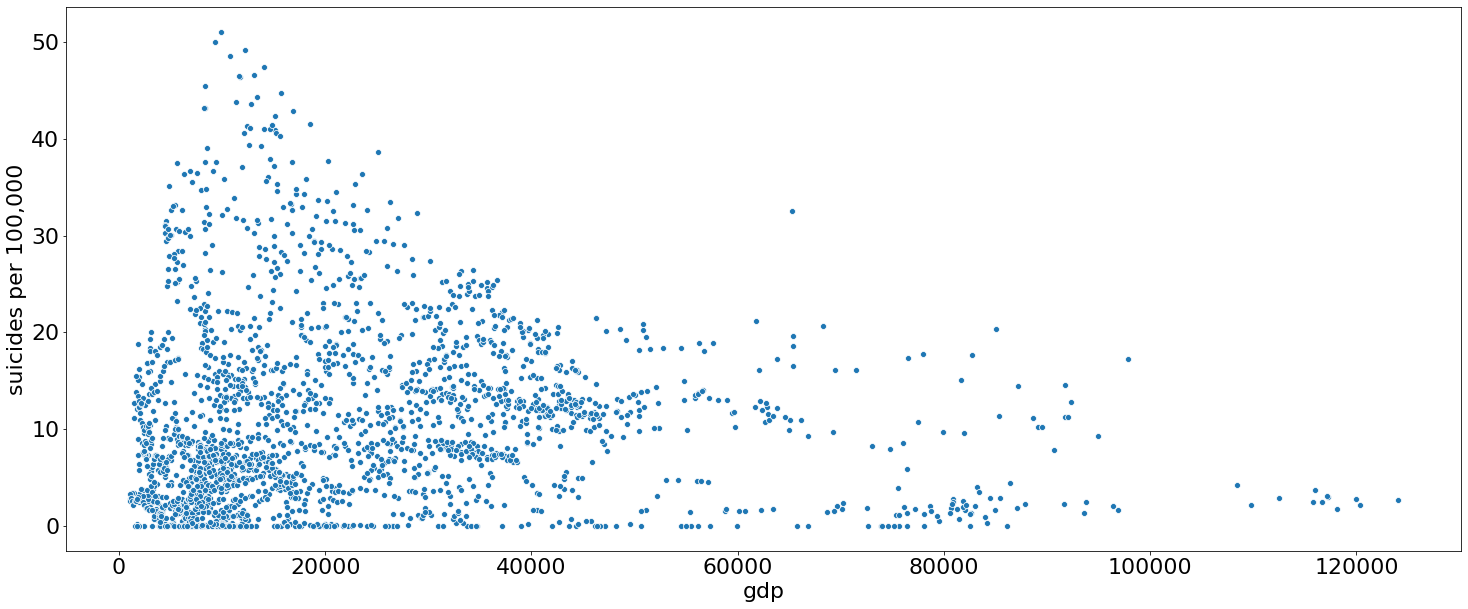

In [89]:
plt.figure(figsize=(25,10))
sns.scatterplot(x="gdp", y="suicides per 100,000", data=df)